<a href="https://colab.research.google.com/github/michelucci/oreilly-london-ai/blob/master/day1/Easy_Network_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Fully connected network with Keras

Author: Umberto Michelucci (umberto.michelucci@hslu.ch)

## Exercises

### Exercise 1:
Try to increase the network size (increasing the number of layers and number of neurons) and see if you get better results.

### Exercise 2:
Try to reduce the network size to just one neuron. What kind of neuron do you need to use (activation function, output, etc.) to classify the images? And what results do you get?

### Exercise 3:
Check for overfitting. Is the network overfitting? Can you tell?

In [6]:
import numpy as np
np.object = object   
np.bool = bool   
np.int = int  
np.float = float    
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Text(0.5, 1.0, 'Label is 9')

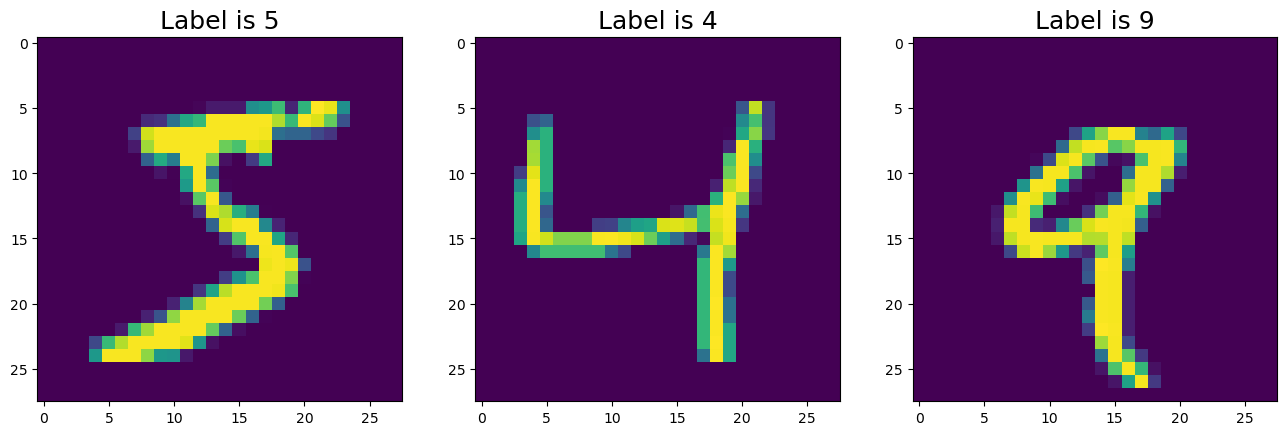

In [9]:
fig = plt.figure(figsize = (16,5))
fig.add_subplot(1,3,1)
plt.imshow(x_train[0])
plt.title("Label is "+ str(y_train[0]), fontsize = 18)
fig.add_subplot(1,3,2)
plt.imshow(x_train[2])
plt.title("Label is "+ str(y_train[2]), fontsize = 18)
fig.add_subplot(1,3,3)
plt.imshow(x_train[4])
plt.title("Label is "+ str(y_train[4]), fontsize = 18)

## Sequential model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), #784 pixels
  tf.keras.layers.Dense(128, activation='relu'), #128 wurde ohne weiteren Grund gewählt, kann auch anders lauten
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
print(history.history)

Let's check how the network is learning by plotting the loss function for the training and test datasets. This is a handy way to check if there is any overfitting or if the network is not learning properly.

### Learning Assessment

In [ ]:
plt.plot(history.history['loss'], label = 'Training Loss Function')
plt.plot(history.history['val_loss'], label = 'Test Loss Function')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.ylim(None, 1)
plt.legend()
plt.show()

### Prediction check

In [ ]:
model.predict(x_train[0][np.newaxis,:])[0]

In [ ]:
plt.bar(np.arange(0,10,1), model.predict(x_train[0][np.newaxis,:])[0])
plt.title ("Proabibility for each integer", fontsize = 18)
plt.show()

## Functional APIs

Networks can be built with the Sequential approach by using the ```Sequential()``` constructor, or by using functional API, as shown below. The functional API will give much more flexibility to build more flexible network architectures.

In [ ]:
input = tf.keras.layers.Input(shape = (28,28), name = 'Input_Layer')
layer = tf.keras.layers.Flatten()(input)
layer = tf.keras.layers.Dense(128, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(10, activation='softmax')(layer)

model = tf.keras.models.Model(inputs=input, outputs=layer)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
model.predict(x_train[0][np.newaxis,:])[0]

In [ ]:
plt.bar(np.arange(0,10,1), model.predict(x_train[0][np.newaxis,:])[0])
plt.title ("Proabibility for each integer", fontsize = 18)
plt.show()

In [ ]:
print(y_train[0])

## Custom Training Loop

In [ ]:
input = tf.keras.layers.Input(shape = (28,28), name = 'Input_Layer')
layer = tf.keras.layers.Flatten()(input)
layer = tf.keras.layers.Dense(128, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(10, activation='softmax')(layer)

model = tf.keras.models.Model(inputs=input, outputs=layer)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size = 32

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
epochs = 5
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))

In [ ]:
model.evaluate(x_test, y_test)